# Classifying african names using RNN

In this notebook, I will be building a simple character-level RNN to classify words.

The data is sourced using [name-dataset](https://github.com/philipperemy/name-dataset) libary.


## Data preparation

Country names and their short code
```
Burundi:      BI             
Bostwana:     BW             
Burkina Faso: BF
Cameroon:     CA             
Djibouti:     DJ              
Ghana:        GH                
Namibia:      NA              
Nigeria:      NG              
South Africa: ZA
```

In [1]:
# Importing libaries

from io import open
import glob
import os


def find_files(path: str):
  ''' Return all availble files that have a .txt extension, from the given path.'''
  return glob.glob(path)



import unicodedata
import string

# Combining the ascii character with some other characters.
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )
# print(unicode_to_ascii('Ślusàrski')) -> Slusarski


def read_lines(filename):
  '''Read a file, convert all text to plain ASCII and return as words in a list.'''
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicode_to_ascii(line) for line in lines]



# Build a vocabulary_line dictionary,
# mapping multiples names (item) to country (key). example {'country_code': [names]}
category_lines = {}
all_categories = []
path = '/content/drive/MyDrive/Colab_Notebooks/So_help_me_God/common_countries_name/*.txt'

for filename in find_files(path):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = read_lines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

In [2]:
all_categories

['BI', 'BW', 'GH', 'ZA', 'CA', 'BF', 'NG', 'NA', 'DJ']

In [3]:
print(category_lines['NG'][:5])

['Hammed', 'Abubakar', 'Taiwo', 'Hope', 'Olumide']


## Name to Tensor
In this part, the inputed name is converted into tensors, using the One-hot-vector method.

In [4]:
import torchtext, torch

def letter_to_index(letter):
  '''Returns the index of a single passed character/letter.'''
  return all_letters.find(letter)

def letter_to_tensor(letter):
  '''One hot vector. example [0,0,0,1,0,0] where only one index gets 1 rest is 0.'''
  tensor = torch.zeros(1, n_letters)
  tensor[0][letter_to_index(letter)] = 1
  return tensor


def line_to_tensor(line):
  '''Turn a name into tensor'''
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letter_to_index(letter)] = 1
  return tensor

# In each dimension only one index becomes 1, rest is 0.
line_to_tensor('abc')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

# Creating the Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2h = nn.Linear(input_size, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    # combined = torch.cat((input, hidden), 1) # shape torch.Size([1, input+hidden])
    # hidden = self.i2h(combined)
    hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories) # n_letter(57 characters) as input, n_categories: numbers of countries to predict

## Running a single step
in this step only one value in the name is passed through the model.


In [6]:
input = line_to_tensor('Daniel') # torch.Size([6, 1, 57])
print(input[0].shape) # 'D' torch.Size([1, 57])
hidden = torch.zeros(1, n_hidden) # same size as above

output, next_hidden = rnn(input[0], hidden) # forward pass
output # Propabilities prediction of each country the name might belong

torch.Size([1, 57])


tensor([[-2.3844, -2.1900, -2.3454, -2.2143, -2.1061, -2.2066, -2.1551, -2.0854,
         -2.1288]], grad_fn=<LogSoftmaxBackward0>)

## Training

In [7]:
def category_from_output(output: torch.Tensor):
  '''
  a function to return the top predicted country for a name
  '''
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

category_from_output(output)

('NA', 7)

## Returns a random training example
a function to quickly get a trainng example. To return name and its language

In [8]:
import random

def random_choice(l):
  '''returns a random character from l, based on indexing.'''
  return l[random.randint(0, len(l)-1)]

def random_training_example():
  '''Returns a random training example.'''
  category = random_choice(all_categories) # returns a random country code
  line = random_choice(category_lines[category]) # gets a name.
  category_tensor = torch.tensor([all_categories.index(category)],
                                 dtype=torch.long) # returns the index position of country_code in all_categories
  line_tensor = line_to_tensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = random_training_example()
  print(category, line, category_tensor.item(), line_tensor.shape)

BF Nabil Inza 5 torch.Size([10, 1, 57])
BW Baleseng 1 torch.Size([8, 1, 57])
GH Comfort 2 torch.Size([7, 1, 57])
DJ Nina 8 torch.Size([4, 1, 57])
BI Leana 0 torch.Size([5, 1, 57])
BF Phylomene 5 torch.Size([9, 1, 57])
BW Dithapelo 1 torch.Size([9, 1, 57])
BI Dieudone 0 torch.Size([8, 1, 57])
GH Bro 2 torch.Size([3, 1, 57])
BF Domba 5 torch.Size([5, 1, 57])


In [9]:
line_tensor.shape

torch.Size([5, 1, 57])

## Training the network

In [10]:
criterion = nn.NLLLoss() # loss function
learning_rate = 0.005

def train(category_tensor: torch.Tensor, line_tensor: torch.Tensor):
  """
  Train the model on given a name (e.g., 'Daniel') through individual characters.
  Indexing through line_tensor[i] from [len(name), 1, n_characters_general].

  Parameters
  ----------
  category_tensor:
      index position of country_code in all_categories
  line_tensor:
      a tensor of shape ([name, 1, n_letters(vocab)]).
      it represent a name in one-hot vector.
  """
  hidden = rnn.init_hidden() # hidden unit is given an extra dimension remember.

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden) # each character pass through the model of shape, [1, 57] each.

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [11]:
import time, math

n_iters = 100000
print_every = 5_000
plot_every = 1_000

# keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return f'{m}m {s:.0f}s'

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = random_training_example()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = category_from_output(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print(f'{iter} {iter / n_iters * 100:.0f}% ({time_since(start)}) {loss:.4f} {line} {guess} / {correct}')
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 20s) 2.3387 Lateef CA / ✗ (NG)
10000 10% (0m 31s) 1.8694 Salomay DJ / ✗ (GH)
15000 15% (0m 43s) 3.4406 Simon DJ / ✗ (ZA)
20000 20% (0m 54s) 1.6403 Chem CA / ✗ (DJ)
25000 25% (1m 6s) 2.2264 Moumouni DJ / ✗ (BF)
30000 30% (1m 17s) 1.9219 Gladys NA / ✗ (NG)
35000 35% (1m 28s) 0.8376 Ogechukwu NG / ✓
40000 40% (1m 40s) 2.7154 Felicity BI / ✗ (GH)
45000 45% (1m 53s) 1.6113 Olaide DJ / ✗ (NG)
50000 50% (2m 4s) 0.5139 Twum GH / ✓
55000 55% (2m 16s) 3.1393 Doug GH / ✗ (CA)
60000 60% (2m 26s) 0.7805 Disang BW / ✓
65000 65% (2m 37s) 0.1506 Harerimana BI / ✓
70000 70% (2m 49s) 0.9798 Wynand NA / ✓
75000 75% (3m 0s) 1.2273 Donavine BI / ✓
80000 80% (3m 12s) 1.8989 Lynda ZA / ✗ (CA)
85000 85% (3m 22s) 1.2720 William NG / ✗ (CA)
90000 90% (3m 34s) 3.1327 Violet CA / ✗ (ZA)
95000 95% (3m 46s) 2.3573 Boniface BI / ✗ (BW)
100000 100% (3m 57s) 2.6719 Louise BI / ✗ (CA)


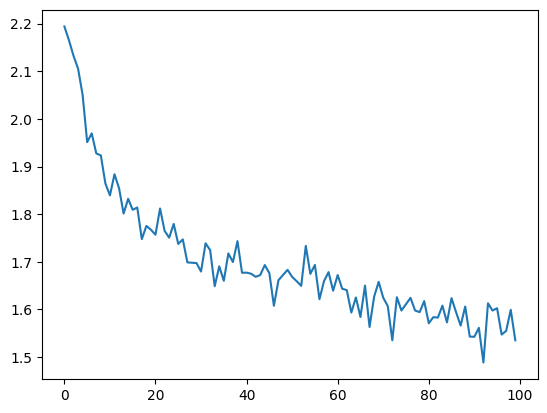

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate the results

In [13]:
def evaluate(line_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  return output

def predict(input_line, n_predictions=3):
  print(f'\n {input_line}')

  with torch.no_grad(): # we are no longer training, but evaluating
    output = evaluate(line_to_tensor(input_line))

    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

In [17]:
predict('precious')


 precious
(-0.61) NA
(-1.64) NG
(-2.12) GH


reference: Pytorch intermidate tutorial [Link](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorialhttps://)